In [1]:
#python 2 and 3 comptibility
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import json
import io
import gzip
import base64
from astropy.io import fits
import matplotlib.pylab as plt
import pickle as pkl
import numpy as np
%matplotlib inline

data_path = '/home/ereyes/Alerce/ZTF_7_18'

#with open('/home/asceta/LRPpaper/datasets/ZTF/reals.pkl', 'rb') as f:
#    reals = pkl.load(f)
#with open('/home/asceta/LRPpaper/datasets/ZTF/bogus.pkl', 'rb') as f:
#    bogus = pkl.load(f)
    
#print('Number of reals: %d' %len(reals))
#print('Number of bogus: %d' %len(bogus))

In [2]:
def json2list(path):
    #load json
    with open(path, "r") as f:
        dataset = json.load(f)
    
    samples_list = []
    for i in range(len(dataset['query_result'])):

        channels = []
        for k, imstr in enumerate(['Template', 'Science', 'Difference']):
            stamp = dataset['query_result'][i]['cutout'+imstr]['stampData']
            stamp = base64.b64decode(stamp["$binary"].encode())

            with gzip.open(io.BytesIO(stamp), 'rb') as f:
                with fits.open(io.BytesIO(f.read())) as hdul:
                    img = hdul[0].data
                    channels.append(img)
        samples_list.append(np.array(channels))
    return samples_list

In [3]:
def check_samples_shapes(samples):
    miss_shaped_sample_idx = []
    for i in range(len(samples)):
        sample = samples[i]
        if sample.shape[0]!=3 or sample.shape[1]!=63 or sample.shape[2]!=63:
            #print("sample %i of shape %s" %(i,str(sample.shape)))
            miss_shaped_sample_idx.append(i)
    return miss_shaped_sample_idx

#misshaped_reals = check_samples_shapes(reals)
#misshaped_bogus = check_samples_shapes(bogus)
 
#print('Number of misshaped reals: %d' %len(misshaped_reals))
#print('Number of misshaped bogus: %d' %len(misshaped_bogus))

In [4]:
#TODO padding non trivial by determining center

def clean_misshaped(samples):
    miss_shaped_sample_idx = check_samples_shapes(samples)
    print('%d misshaped samples removed' %len(miss_shaped_sample_idx))
    for index in sorted(miss_shaped_sample_idx, reverse=True):
        samples.pop(index)
    return np.moveaxis(np.array(samples), 1, -1)

#reals_clean = clean_misshaped(reals)
#bogus_clean = clean_misshaped(bogus)

In [5]:
def crop_at_center(sample_numpy, cropsize=21):
    center = int((sample_numpy.shape[1]-1)/2)
    crop_side = int((cropsize-1)/2)
    crop_begin = center-crop_side
    crop_end = center+crop_side+1
    #print(center)
    #print(crop_begin, crop_end)
    return sample_numpy[:,crop_begin:crop_end,crop_begin:crop_end,:]

#reals_croped = crop_at_center(clean_misshaped(reals))
#bogus_croped = crop_at_center(clean_misshaped(bogus))

In [6]:
def zero_fill_nans(samples_numpy):
    samples_with_nan_idx = []
    for i in range(samples_numpy.shape[0]):
        if(np.isnan(samples_numpy[i,...]).any()):
            samples_with_nan_idx.append(i)
    print('%d samples with NaNs' %len(samples_with_nan_idx))
    return np.nan_to_num(samples_numpy)

#reals_croped_padded = zero_fill_nans(crop_at_center(clean_misshaped(reals)))
#bogus_croped_padded = zero_fill_nans(crop_at_center(clean_misshaped(bogus)))

In [13]:
def remove_nans(samples_numpy):
    samples_no_nan = []
    count = 0
    for i in range(samples_numpy.shape[0]):
        if not (np.isnan(samples_numpy[i,...]).any()):
            samples_no_nan.append(samples_numpy[i,...])
    #print('%d samples with NaNs' %len(samples_with_nan_idx))
    return np.array(samples_no_nan)

#reals_croped_padded = zero_fill_nans(crop_at_center(clean_misshaped(reals)))
#bogus_croped_padded = zero_fill_nans(crop_at_center(clean_misshaped(bogus)))

In [7]:
#normalice each channel individually. Every channel of every sample will be 0-1 normalized
def normalize_01(samples_numpy):
    for i in range(samples_numpy.shape[0]):
        for j in range(samples_numpy.shape[3]):
            sample = samples_numpy[i,:,:,j]
            normalized_sample = (sample-np.min(sample))/np.max(sample-np.min(sample))
            samples_numpy[i,:,:,j] = normalized_sample
    return samples_numpy



In [8]:
def print_sample(img):
    fig = plt.figure()
    for k, imstr in enumerate(['Template', 'Science', 'Difference']):
        ax = fig.add_subplot(1,3,k+1)
        ax.axis('off')
        ax.set_title(imstr)
        ax.matshow(img[...,k])
        

# preprocessing

In [23]:
reals = remove_nans(clean_misshaped(json2list(data_path+'/broker_reals.json')))
#bogus_croped_padded_norm = normalize_01(zero_fill_nans(crop_at_center(clean_misshaped(json2list(data_path+'/broker_bogus.json')))))

118 misshaped samples removed


In [24]:
reals.shape

(6054, 63, 63, 3)

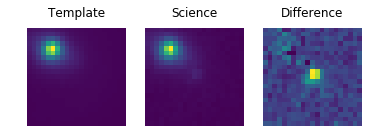

In [19]:
print_sample(reals_croped_padded_norm[1050,...])

In [21]:
np.max(reals_croped_padded_norm)

1.0

In [22]:
np.min(reals_croped_padded_norm)

0.0

# Save to pickle

In [ ]:
#with open('/home/asceta/LRPpaper/datasets/ZTF/reals_normed.pkl', 'wb') as f:
#    pkl.dump(reals_croped_padded_norm, f)
#with open('/home/asceta/LRPpaper/datasets/ZTF/bogus_normed.pkl', 'wb') as f:
#    pkl.dump(bogus_croped_padded_norm, f)

# Data summary

In [16]:
reals =json2list(data_path+'/broker_reals.json')
bogus =json2list(data_path+'/broker_bogus.json')

print('Number of reals: %d' %len(reals))
print('Number of bogus: %d' %len(bogus))

Number of reals: 7410
Number of bogus: 1980


In [17]:
reals_noMissShape = clean_misshaped(reals)

118 misshaped samples removed


In [18]:
reals_noMissShape.shape

(7292, 63, 63, 3)

In [21]:
count = 0
for i in range(reals_noMissShape.shape[0]):
        if(np.isnan(reals_noMissShape[i,...]).any()):
            count+=1
print('%d samples with NaNs' %count)


1238 samples with NaNs


In [12]:
print("Reals")
reals_croped_padded_norm = normalize_01(zero_fill_nans(crop_at_center(clean_misshaped(json2list(data_path+'/broker_reals.json')))))
print("\nBogus")
bogus_croped_padded_norm = normalize_01(zero_fill_nans(crop_at_center(clean_misshaped(json2list(data_path+'/broker_bogus.json')))))

Reals
118 misshaped samples removed
263 samples with NaNs

Bogus
29 misshaped samples removed
1482 samples with NaNs


In [13]:
print('Number of reals after preprocessing: %d' % reals_croped_padded_norm.shape[0])
print('Number of bogus after preprocessing: %d' % bogus_croped_padded_norm.shape[0])

Number of reals after preprocessing: 7292
Number of bogus after preprocessing: 1951


# View Data

In [14]:
reals_croped_padded =zero_fill_nans(crop_at_center(clean_misshaped(json2list(data_path+'/broker_reals.json'))))
bogus_croped_padded= zero_fill_nans(crop_at_center(clean_misshaped(json2list(data_path+'/broker_bogus.json'))))

118 misshaped samples removed
263 samples with NaNs
29 misshaped samples removed
1482 samples with NaNs


In [25]:
names = ['Template', 'Science', 'Difference']
reals_croped_padded[0,...][:,:,0].max()

1661.1898

Template MIN:174.779037 MAX:1661.189819
Science MIN:28.504150 MAX:1409.249512
Difference MIN:-182.667297 MAX:587.606812


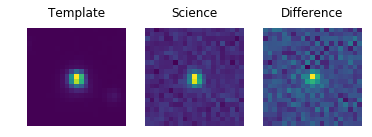

Template MIN:173.734329 MAX:1542.865234
Science MIN:131.395233 MAX:881.292236
Difference MIN:-37.510204 MAX:452.738739


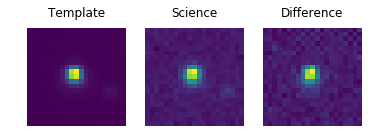

Template MIN:174.378769 MAX:1661.044434
Science MIN:135.198364 MAX:1343.542236
Difference MIN:-83.936707 MAX:451.580414


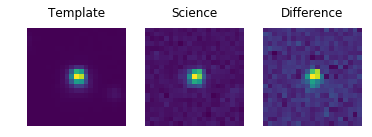

Template MIN:174.624878 MAX:1750.367676
Science MIN:151.667282 MAX:1757.899292
Difference MIN:-46.698341 MAX:226.780121


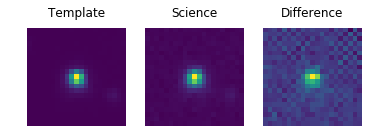

Template MIN:174.636002 MAX:1668.680176
Science MIN:97.866943 MAX:2072.683594
Difference MIN:-121.516235 MAX:392.778748


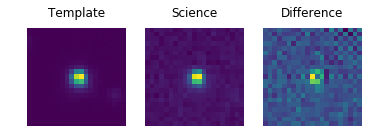

Template MIN:169.308655 MAX:198.214233
Science MIN:50.661133 MAX:331.250244
Difference MIN:-130.493652 MAX:150.579300


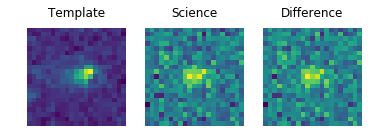

Template MIN:281.588348 MAX:1750.717041
Science MIN:221.468445 MAX:1612.409912
Difference MIN:-63.554531 MAX:178.085190


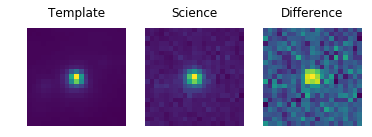

Template MIN:283.202820 MAX:1650.064575
Science MIN:273.450745 MAX:2694.569092
Difference MIN:-20.748476 MAX:453.900208


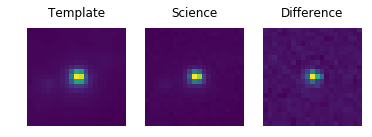

Template MIN:281.795563 MAX:1783.808716
Science MIN:265.288055 MAX:2998.438721
Difference MIN:-107.928116 MAX:366.770752


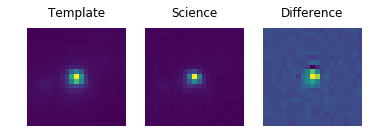

Template MIN:281.551086 MAX:1611.439087
Science MIN:272.872925 MAX:1963.356812
Difference MIN:-52.456104 MAX:311.819855


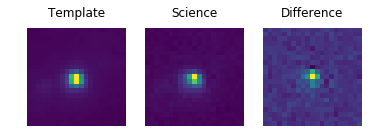

In [29]:
for i in range(10):
    img = reals_croped_padded[i,...]
    for j in range(len(names)):
        print('%s MIN:%f MAX:%f' %(names[j], img[:,:,j].min(), img[:,:,j].max()))
    print_sample(img)
    plt.show()

Template MIN:0.000000 MAX:393.298553
Science MIN:0.000000 MAX:658.942871
Difference MIN:-222.302216 MAX:286.011505


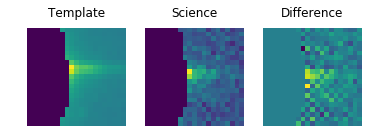

Template MIN:0.000000 MAX:438.308014
Science MIN:0.000000 MAX:925.511963
Difference MIN:-217.696457 MAX:673.846130


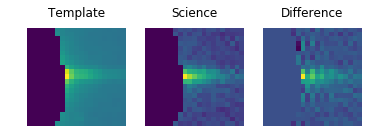

Template MIN:0.000000 MAX:427.413483
Science MIN:0.000000 MAX:834.328674
Difference MIN:-33.452217 MAX:355.378387


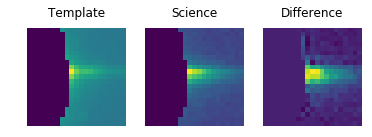

Template MIN:0.000000 MAX:388.520538
Science MIN:0.000000 MAX:862.560669
Difference MIN:-144.350082 MAX:571.728333


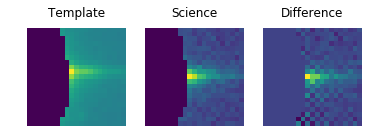

Template MIN:0.000000 MAX:407.434814
Science MIN:0.000000 MAX:738.525391
Difference MIN:-122.395554 MAX:352.216400


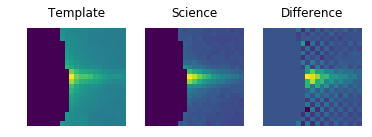

Template MIN:0.000000 MAX:429.119263
Science MIN:0.000000 MAX:511.605286
Difference MIN:-73.128235 MAX:120.640274


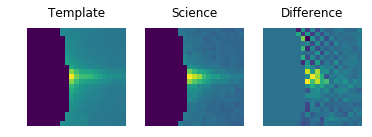

Template MIN:0.000000 MAX:414.218170
Science MIN:0.000000 MAX:744.561401
Difference MIN:-41.867870 MAX:340.542480


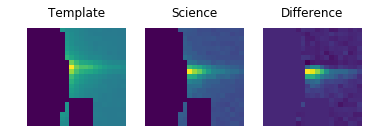

Template MIN:0.000000 MAX:423.942413
Science MIN:0.000000 MAX:694.437866
Difference MIN:-94.927635 MAX:258.339935


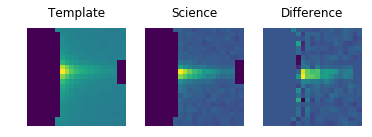

Template MIN:0.000000 MAX:425.878754
Science MIN:0.000000 MAX:609.225220
Difference MIN:-47.017757 MAX:130.158859


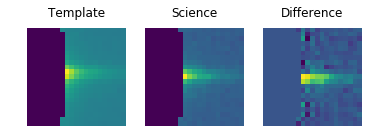

Template MIN:0.000000 MAX:260.151703
Science MIN:0.000000 MAX:360.288605
Difference MIN:-90.566833 MAX:171.209152


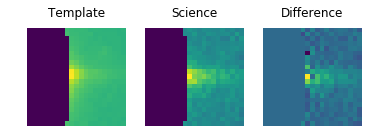

In [31]:
for i in range(10):
    img = bogus_croped_padded[100+i,...]
    for j in range(len(names)):
        print('%s MIN:%f MAX:%f' %(names[j], img[:,:,j].min(), img[:,:,j].max()))
    print_sample(img)
    plt.show()

# SEE SKY

In [32]:
for i in range(10):
    img = reals_croped_padded[i,...]

    print(img[:,:,j])

[[ 6.95295486e+01  1.05798321e+01  1.01173073e+02  8.71509476e+01
   5.22682095e+00 -2.95836735e+01 -2.74795647e+01 -8.07226562e+00
   1.71750202e+01 -2.00160065e+01 -3.35134292e+00 -8.05273666e+01
   5.62913246e+01 -1.15469513e+02  5.49537201e+01 -5.51514864e+00
   2.13207722e+01 -4.94794731e+01 -8.89375534e+01  1.70651188e+01
  -1.12756264e+02]
 [ 9.18322945e+00 -4.96559334e+01 -2.46019554e+01 -4.55708275e+01
   6.72096786e+01 -2.05747013e+01 -1.18265579e+02 -1.87555656e+01
  -2.93209209e+01  6.21373405e+01  1.84564471e+00  5.84955215e+00
  -8.89045715e-01  1.28681726e+01 -6.68954468e+01 -3.56851883e+01
  -4.09504662e+01 -6.13714218e+00  2.79103255e+00 -5.77523346e+01
  -7.33037424e+00]
 [-1.22735535e+02 -1.59217014e+01  2.79945469e+01 -4.62574043e+01
   5.27652321e+01  6.87485809e+01 -5.39788017e+01 -6.11804924e+01
   8.32287292e+01 -1.02696182e+02  2.30162048e+00 -1.35315674e+02
   3.34444885e+01  3.80279770e+01  4.83799171e+01  4.32295456e+01
   3.56836796e+00  4.89701424e+01  3.8